In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('arxiv_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51774 entries, 0 to 51773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     51774 non-null  object
 1   summaries  51774 non-null  object
 2   terms      51774 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [5]:
df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [6]:
df = df.drop_duplicates(subset=['titles', 'summaries'])

In [7]:
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38985 entries, 0 to 51772
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     38985 non-null  object
 1   summaries  38985 non-null  object
 2   terms      38985 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


### Document Length Analysis
We analyze the distribution of summaries length to understand content variation.


In [9]:
# Sample 100 rows
df_sample = df.sample(n=1000, random_state=42)

count    1000.000000
mean      171.464000
std        46.254256
min        38.000000
25%       139.000000
50%       170.000000
75%       201.000000
max       307.000000
Name: summary_length, dtype: float64


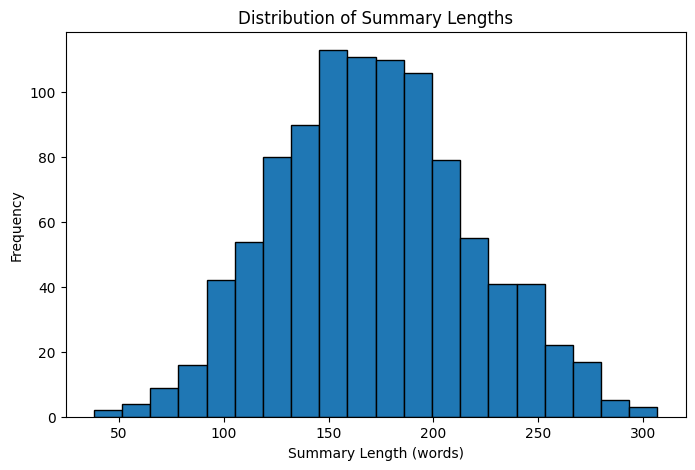

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Compute document lengths
df_sample["summary_length"] = df_sample["summaries"].apply(lambda x: len(x.split()))

# Display summary statistics
print(df_sample["summary_length"].describe())

# Plot histogram of document lengths
plt.figure(figsize=(8,5))
plt.hist(df_sample["summary_length"], bins=20, edgecolor='black')
plt.xlabel("Summary Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Summary Lengths")
plt.show()


In [11]:
# 3. Vocabulary Size Calculation
# To get an estimate of the dataset's vocabulary size:

from collections import Counter

# Join all text data and count unique words
all_words = " ".join(df_sample["summaries"]).split()
vocab_count = Counter(all_words)

print(f"Vocabulary size: {len(vocab_count)}")

Vocabulary size: 18325


               Topic  Count
0              cs.CV    571
4              cs.LG    565
5            stat.ML    302
7              cs.AI    148
12             cs.RO     39
..               ...    ...
108  physics.ins-det      1
109          nlin.CD      1
110   physics.bio-ph      1
111          math.DS      1
112  physics.comp-ph      1

[113 rows x 2 columns]


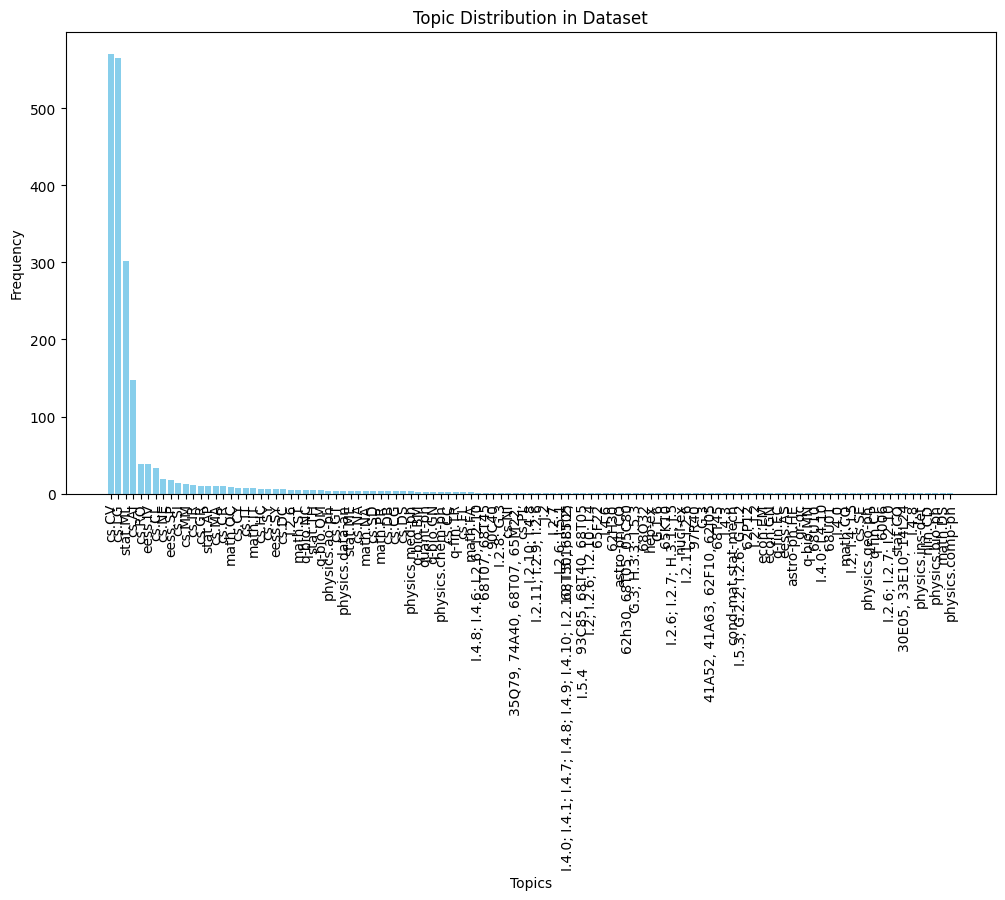

In [12]:
# # 4. Topic Distribution Analysis
# # The terms column contains multiple topic labels per document. We will flatten and count their occurrences.

# from collections import Counter
# import pandas as pd
# import matplotlib.pyplot as plt

# # Count occurrences of each unique title (topic)
# topic_counts = df["terms"].value_counts()

# # Convert to DataFrame for visualization
# topic_df = topic_counts.reset_index()
# topic_df.columns = ["Topic", "Count"]

# # Display topic frequency
# print(topic_df)

# # Plot topic distribution
# plt.figure(figsize=(10, 5))
# plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
# plt.xticks(rotation=90)  # Rotate for better readability if too many topics
# plt.xlabel("Topics")
# plt.ylabel("Frequency")
# plt.title("Topic Distribution in Dataset")
# plt.show()

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import ast  # To safely convert string lists into actual lists

# Flatten the topic lists
all_topics = []
for topics in df_sample["terms"]:
    topic_list = ast.literal_eval(topics)  # Convert string list to actual list
    all_topics.extend(topic_list)  # Add all topics to a single list

# Count occurrences of each unique topic
topic_counts = Counter(all_topics)

# Convert to DataFrame for visualization
topic_df = pd.DataFrame(topic_counts.items(), columns=["Topic", "Count"]).sort_values(by="Count", ascending=False)

# Display topic frequency
print(topic_df)

# Plot topic distribution
plt.figure(figsize=(12, 6))
plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
plt.xticks(rotation=90)  # Rotate for better readability if too many topics
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.title("Topic Distribution in Dataset")
plt.show()


In [26]:
import torch
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast
import numpy as np

# Load dataset (assuming df_sample is already loaded)
df_sample["terms"] = df_sample["terms"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Initialize embedding model
embedding_model = SentenceTransformer("BAAI/bge-small-en")

# Compute embeddings for dataset documents
document_texts = df_sample["summaries"].tolist()  # Make sure column name is correct
document_embeddings = embedding_model.encode(document_texts, convert_to_tensor=True)

# Function to retrieve top-k similar documents
def retrieve_documents(query, k=3):
    query_embedding = embedding_model.encode(query, convert_to_tensor=True)
    similarities = cosine_similarity(query_embedding.unsqueeze(0), document_embeddings)[0]  # Compute similarity
    top_k_indices = np.argsort(similarities)[-k:][::-1]  # Get top-k indices
    return df_sample.iloc[top_k_indices]  # Ensure df_sample is used correctly

# Initialize LLM (FLAN-T5)
flan_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
flan_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")

# Function to generate response based on retrieved documents
def generate_response(query, k=3):
    retrieved_docs = retrieve_documents(query, k)
    context = " ".join(retrieved_docs["summaries"].tolist())  # Ensure column name is correct

    # Format prompt for T5
    prompt = f"Answer the following question based on the context:\n\nContext: {context}\n\nQuestion: {query}\n\nAnswer:"
    input_ids = flan_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).input_ids

    # Generate response
    output_ids = flan_model.generate(input_ids, max_length=500)
    answer = flan_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return answer

# Example query test
query = "What is the role of convolutional neural networks in computer vision?"
response = generate_response(query, k=3)
print("Generated Response:", response)


Generated Response: (iii)


In [31]:
query = "What is the role of convolutional neural networks in computer vision?"
retrieved_docs = retrieve_documents(query, k=3)

print("Retrieved Documents:")
# print("Columns in retrieved_docs:", retrieved_docs.columns)
print(retrieved_docs[["titles", "summaries"]])  # Print titles & summaries of retrieved docs


Retrieved Documents:
                                                  titles  \
10969  A Comparison of Deep Learning Classification M...   
3841   Texture Synthesis Using Convolutional Neural N...   
5441   Object detection for crabs in top-view seabed ...   

                                               summaries  
10969  In recent years, deep learning has made brilli...  
3841   Here we introduce a new model of natural textu...  
5441   This report presents the application of object...  


In [24]:
# Example query test
query = "What is the role of convolutional neural networks in computer vision?"
response = generate_response(query, k=3)
print("Generated Response:", response)

Generated Response: (iii)


0           [cs.CV, cs.LG]
1    [cs.CV, cs.AI, cs.LG]
2           [cs.CV, cs.AI]
3                  [cs.CV]
4           [cs.CV, cs.LG]
Name: terms, dtype: object
